# MODEL2: Hate Speech Detection 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string 
import re
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import itertools
from sklearn.utils import resample

## Data preparation

In [2]:
data = pd.read_csv('../../data/hate-speech-and-offensive-language/hate-speech-and-offensive-language.csv', index_col=0)
data['tweet'] = data['tweet'].str.replace(r'^.*?RT @\w+: ', '', regex=True)
data.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,As a woman you shouldn't complain about cleani...
1,3,0,3,0,1,boy dats cold...tyga dwn bad for cuffin dat ho...
2,3,0,3,0,1,You ever fuck a bitch and she start to cry? Yo...
3,3,0,2,1,1,@viva_based she look like a tranny
4,6,0,6,0,1,The shit you hear about me might be true or it...


### Columns explanation

count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).

hate_speech = number of CF users who judged the tweet to be hate speech.

offensive_language = number of CF users who judged the tweet to be offensive.

neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.

class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither

## Visualizations

In [3]:
data = data[['class', 'tweet']]

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\davyd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\davyd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
class_labels = {0: "Hate Speech", 1: "Offensive Language", 2: "Neither"}
data["class_label"] = data["class"].map(class_labels)

### Class Distribution 

C:\Users\davyd\AppData\Local\Temp\ipykernel_20824\3895249606.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data["class_label"], palette="viridis")


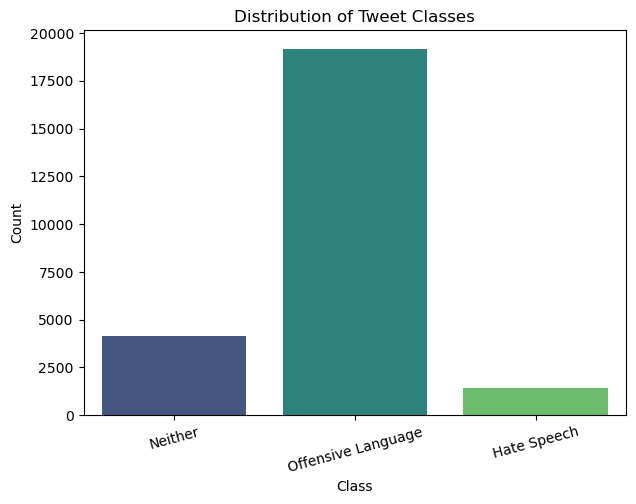

In [6]:
plt.figure(figsize=(7, 5))
sns.countplot(x=data["class_label"], palette="viridis")
plt.title("Distribution of Tweet Classes")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=15)
plt.show()

Most of the tweets are classified as offensive language, thats can be a problem for the model, because classes are unbalanced.

### Tweet Length Distribution per Class

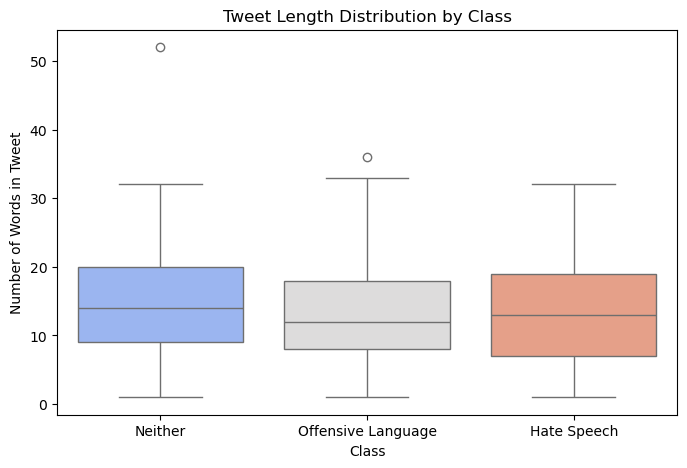

In [7]:
data["tweet_length"] = data["tweet"].apply(lambda x: len(x.split()))  

plt.figure(figsize=(8, 5))
sns.boxplot(x="class_label", y="tweet_length", data=data, hue="class_label", dodge=False, palette="coolwarm", legend=False)  
plt.title("Tweet Length Distribution by Class")
plt.xlabel("Class")
plt.ylabel("Number of Words in Tweet")
plt.show()

Every class has a similar distribution of tweet length.

### Word Cloud for Each Class

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\davyd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


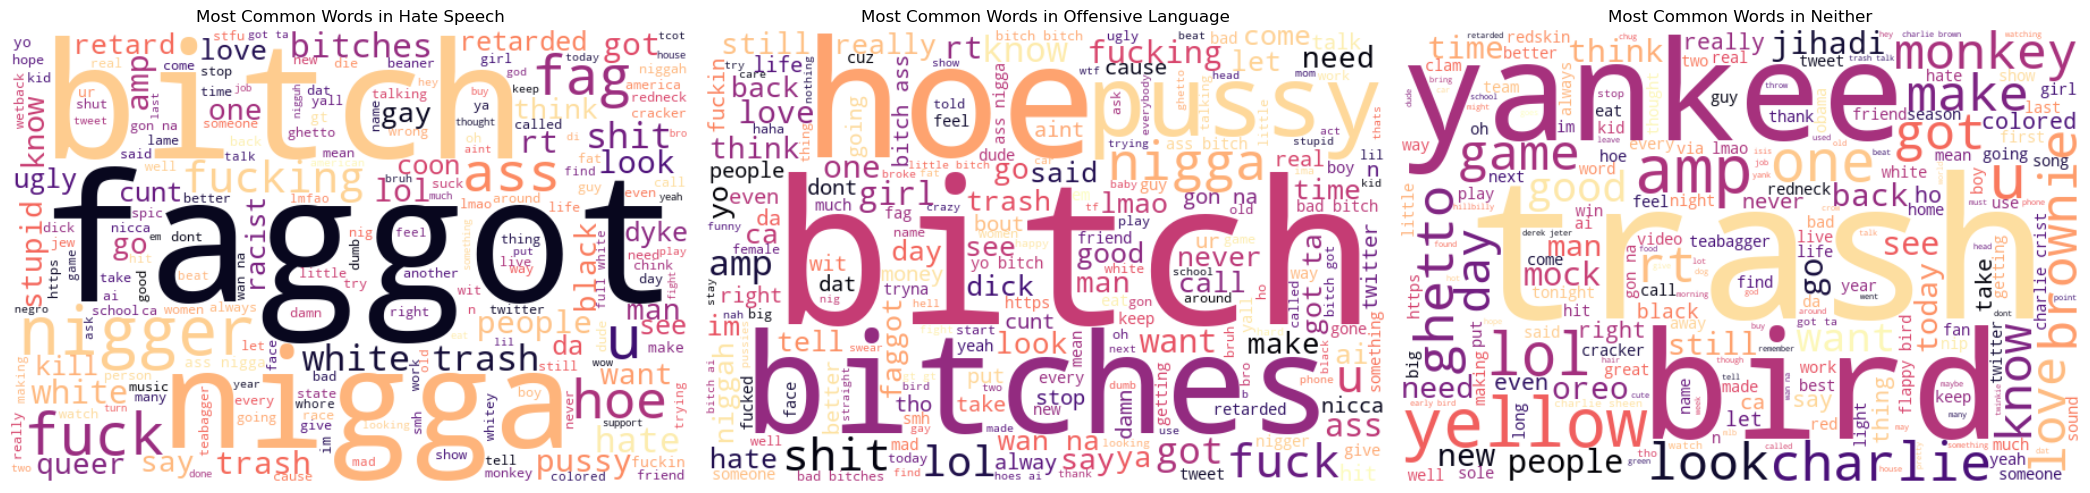

In [8]:
nltk.download('punkt_tab')
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

for i, (class_id, class_name) in enumerate(class_labels.items()):
    text = " ".join(data[data["class"] == class_id]["tweet"]).lower()
    text = " ".join([word for word in word_tokenize(text) if word.isalpha() and word not in stop_words])
    
    wordcloud = WordCloud(width=600, height=400, background_color="white", colormap="magma").generate(text)
    
    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Most Common Words in {class_name}")

plt.tight_layout()
plt.show()

### Top 10 Most Common Bigrams

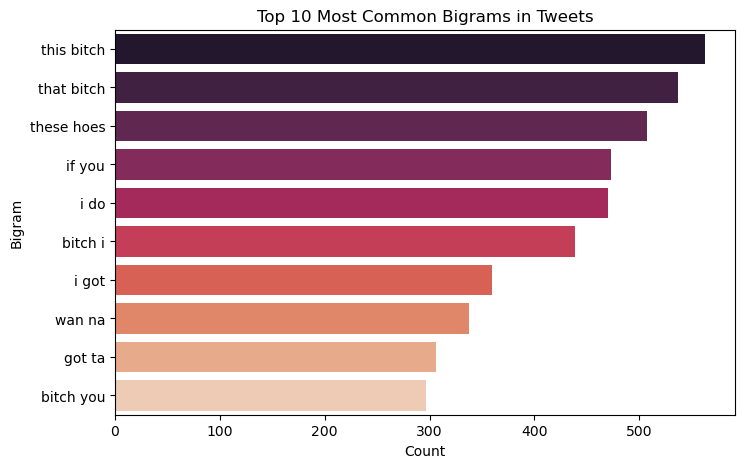

In [9]:
from nltk import bigrams
stop_words = set(["a", "the", "is", "in", "to", "and", "of", "for", "on", "with", "at", "by", "from"])  
def get_bigrams(text):
    words = [word for word in word_tokenize(text.lower()) if word.isalpha() and word not in stop_words]
    return list(bigrams(words))
all_bigrams = list(itertools.chain(*data["tweet"].apply(get_bigrams)))
bigram_counts = Counter(all_bigrams).most_common(10)
bigram_df = pd.DataFrame(bigram_counts, columns=["Bigram", "Count"])
bigram_df["Bigram"] = bigram_df["Bigram"].apply(lambda x: " ".join(x))
plt.figure(figsize=(8, 5))
sns.barplot(y="Bigram", x="Count", data=bigram_df, hue="Bigram", dodge=False, palette="rocket", legend=False)
plt.title("Top 10 Most Common Bigrams in Tweets")
plt.xlabel("Count")
plt.ylabel("Bigram")
plt.show()

## Data Preprocessing

In [10]:
len(data)

24783

In [11]:
data["class"].value_counts()

class
1    19190
2     4163
0     1430
Name: count, dtype: int64

Dataset has a severe imbalance (hate speech being significantly underrepresented), using SMOTE (Synthetic Minority Over-sampling Technique) may not be ideal because:
1. Text data is complex – SMOTE generates synthetic samples by interpolating between existing ones, which works well for numerical data but can create unrealistic text samples.
2. Majority class (offensive language) dominates – Even if SMOTE balances the dataset, the model might still struggle with minority class predictions.

There are some other strategies how to deal in that case:
1. Downsampling the Majority Class (Random Under-sampling)
2. Oversampling the Minority Class (Random Over-sampling)
3. Class Weighting in the Model
4. Data Augmentation

Try a combination of random oversampling (to increase hate speech examples) and class weighting (to prevent bias toward offensive language)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

In [13]:
### 1️⃣ Handle Class Imbalance with Random Oversampling ###
# Separate majority and minority classes
df_majority = data[data['class'] == 1]  # Offensive language (majority)
df_minority_hate = data[data['class'] == 0]  # Hate speech (minority)
df_minority_neither = data[data['class'] == 2]  # Neither (medium size)

In [14]:
# Oversample minority classes
df_minority_hate_upsampled = resample(df_minority_hate, 
                                      replace=True, 
                                      n_samples=len(df_majority) // 2,  
                                      random_state=42)

df_minority_neither_upsampled = resample(df_minority_neither, 
                                         replace=True, 
                                         n_samples=len(df_majority) // 2,  
                                         random_state=42)

In [15]:
# Combine majority class with upsampled minority classes
df_balanced = pd.concat([df_majority, df_minority_hate_upsampled, df_minority_neither_upsampled])

In [16]:
# Shuffle dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [17]:
print(df_balanced['class'].value_counts())

class
1    19190
0     9595
2     9595
Name: count, dtype: int64


In [18]:
### 2️⃣ Text Preprocessing ###
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df_balanced['tweet'] = df_balanced['tweet'].apply(clean_text)

In [19]:
### 3️⃣ Split Data into Train & Test Sets ###
X = df_balanced['tweet']
y = df_balanced['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [20]:
### 4️⃣ Convert Text to Numerical Form (TF-IDF) ###
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
### 5️⃣ Compute Class Weights ###
classes = np.array([0, 1, 2])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = {classes[i]: class_weights[i] for i in range(len(classes))}
print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.3333333333333333, 1: 0.6666666666666666, 2: 1.3333333333333333}


## Model Building

### Logistic Regression

In [64]:
model = LogisticRegression(class_weight=class_weights_dict, max_iter=1000)
model.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight={0: 1.3333333333333333, 1: 0.6666666666666666,
                                 2: 1.3333333333333333},
                   max_iter=1000)

In [65]:
y_pred = model.predict(X_test_tfidf)

In [66]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1919
           1       0.95      0.86      0.90      3838
           2       0.89      0.98      0.93      1919

    accuracy                           0.90      7676
   macro avg       0.89      0.91      0.90      7676
weighted avg       0.90      0.90      0.90      7676

Confusion Matrix:
 [[1746  151   22]
 [ 342 3289  207]
 [  22   25 1872]]


### XGBoost algorithm

In [72]:
xgb_model = XGBClassifier(objective="multi:softmax", num_class=3, eval_metric="mlogloss", use_label_encoder=False)
param_grid = {
    'max_depth': [3, 5, 7],         
    'learning_rate': [0.01, 0.1, 0.3], 
    'n_estimators': [100, 300, 500],
    'subsample': [0.8, 1],      
    'colsample_bytree': [0.8, 1],  
    'gamma': [0, 0.1, 0.3]         
}
grid_search = GridSearchCV(xgb_model, param_grid, scoring='accuracy', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train_tfidf, y_train)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


c:\Users\davyd\miniconda3\envs\PYTHON3.10\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\davyd\miniconda3\envs\PYTHON3.10\lib\site-packages\xgboost\core.py:158: UserWarning: [17:31:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 500, 'subsample': 1}


In [73]:
best_xgb = XGBClassifier(**best_params, objective="multi:softmax", num_class=3, eval_metric="mlogloss", use_label_encoder=False)
best_xgb.fit(X_train_tfidf, y_train)
y_pred = best_xgb.predict(X_test_tfidf)

c:\Users\davyd\miniconda3\envs\PYTHON3.10\lib\site-packages\xgboost\core.py:158: UserWarning: [17:33:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [75]:
from sklearn.metrics import accuracy_score
print("\n🔹 Accuracy:", accuracy_score(y_test, y_pred))
print("🔹 Classification Report:\n", classification_report(y_test, y_pred))


🔹 Accuracy: 0.943460135487233
🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.94      1919
           1       0.98      0.91      0.94      3838
           2       0.91      0.98      0.95      1919

    accuracy                           0.94      7676
   macro avg       0.94      0.95      0.94      7676
weighted avg       0.95      0.94      0.94      7676



In [76]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Confusion Matrix:
 [[1854   57    8]
 [ 166 3504  168]
 [   5   30 1884]]


XGBoost with hyperparameter tuning showed better results than Logistic Regression.

### Naive Bayes

In [77]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]  
}
grid_search_nb = GridSearchCV(nb_model, param_grid, scoring='accuracy', cv=3, verbose=2, n_jobs=-1)
grid_search_nb.fit(X_train_tfidf, y_train)
best_alpha = grid_search_nb.best_params_['alpha']
print("Best Alpha for Naïve Bayes:", best_alpha)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Alpha for Naïve Bayes: 0.1


In [78]:
best_nb = MultinomialNB(alpha=best_alpha)
best_nb.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=0.1)

In [79]:
y_pred_nb = best_nb.predict(X_test_tfidf)

In [80]:
print("\n🔹 Accuracy:", accuracy_score(y_test, y_pred_nb))
print("🔹 Classification Report:\n", classification_report(y_test, y_pred_nb))


🔹 Accuracy: 0.8427566440854611
🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.72      0.78      1919
           1       0.81      0.93      0.86      3838
           2       0.91      0.80      0.85      1919

    accuracy                           0.84      7676
   macro avg       0.86      0.81      0.83      7676
weighted avg       0.85      0.84      0.84      7676



Naive Bayes showed the lowest accuracy, so try one more deep learning model and choose the best one.

### LSTM

In [81]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [22]:
# -------------------------------
# 1. Build the Vocabulary
# -------------------------------
def tokenize(text):
    return text.split()

def build_vocab(texts, min_freq=1):
    """
    Build a vocabulary mapping from token to index.
    We'll reserve index 0 for the padding token and index 1 for unknown tokens.
    """
    counter = Counter()
    for text in texts:
        tokens = tokenize(text)
        counter.update(tokens)
    
    # Starting indices:
    # 0: <PAD>
    # 1: <UNK>
    vocab = {'<PAD>': 0, '<UNK>': 1}
    for token, freq in counter.items():
        if freq >= min_freq:
            vocab[token] = len(vocab)
    return vocab

In [83]:
# -------------------------------
# 2. Create a PyTorch Dataset
# -------------------------------
class TweetDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        """
        texts: list or Series of tweets (preprocessed)
        labels: list or Series of integer labels
        vocab: dictionary mapping tokens to indices
        """
        self.texts = texts
        self.labels = labels
        self.vocab = vocab

    def __len__(self):
        return len(self.texts)

    def text_to_indices(self, text):
        tokens = tokenize(text)
        # Map each token to its index in the vocab (use <UNK> if token not in vocab)
        indices = [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens]
        return torch.tensor(indices, dtype=torch.long)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        seq_indices = self.text_to_indices(text)
        return seq_indices, label

In [84]:
# -------------------------------
# 3. Define a Collate Function for DataLoader
# -------------------------------
def collate_fn(batch):
    """
    Each item in batch is a tuple (seq_tensor, label).
    This function pads sequences to the maximum length in the batch and returns:
        - padded sequences [batch_size, max_seq_len]
        - labels tensor
        - lengths of each original sequence (needed for pack_padded_sequence)
    The batch is also sorted by sequence length in descending order.
    """
    sequences, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long)
    
    # Sort by lengths (descending) for pack_padded_sequence
    lengths, perm_idx = lengths.sort(descending=True)
    sequences = [sequences[i] for i in perm_idx]
    labels = torch.tensor([labels[i] for i in perm_idx], dtype=torch.long)
    
    padded_seqs = pad_sequence(sequences, batch_first=True, padding_value=0)  # 0 is the PAD index
    return padded_seqs, labels, lengths

In [85]:
# -------------------------------
# 4. Define the LSTM Classifier Model
# -------------------------------
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim,
                 n_layers=1, bidirectional=False, dropout=0.5, pad_idx=0):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers,
                            bidirectional=bidirectional, batch_first=True, dropout=dropout if n_layers > 1 else 0)
        
        # Determine the dimension of the LSTM output
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_output_dim, output_dim)
        
    def forward(self, text, lengths):
        """
        text: [batch_size, seq_len]
        lengths: [batch_size] (actual lengths of sequences before padding)
        """
        embedded = self.embedding(text)  # [batch_size, seq_len, embed_dim]
        
        # Pack the sequences for efficiency
        packed_embedded = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=True)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        
        # If bidirectional, concatenate the final forward and backward hidden states
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        
        hidden = self.dropout(hidden)
        logits = self.fc(hidden)  # [batch_size, output_dim]
        return logits

In [86]:
# -------------------------------
# 5. Training and Evaluation Functions
# -------------------------------
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    
    for batch in dataloader:
        sequences, labels, lengths = batch
        sequences = sequences.to(device)
        labels = labels.to(device)
        lengths = lengths.to(device)
        
        optimizer.zero_grad()
        outputs = model(sequences, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * sequences.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += sequences.size(0)
        
    return epoch_loss / total, correct / total

In [87]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in dataloader:
            sequences, labels, lengths = batch
            sequences = sequences.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)
            
            outputs = model(sequences, lengths)
            loss = criterion(outputs, labels)
            
            epoch_loss += loss.item() * sequences.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += sequences.size(0)
    
    return epoch_loss / total, correct / total

In [89]:
train_texts = X_train.tolist()   
train_labels = y_train.tolist()    
test_texts = X_test.tolist()
test_labels = y_test.tolist()

In [90]:
vocab = build_vocab(train_texts, min_freq=1)
vocab_size = len(vocab)
print("Vocabulary size:", vocab_size)

Vocabulary size: 28327


In [91]:
train_dataset = TweetDataset(train_texts, train_labels, vocab)
test_dataset = TweetDataset(test_texts, test_labels, vocab)

In [93]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [96]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [97]:
embed_dim = 128
hidden_dim = 128
output_dim = 3 
n_layers = 1
bidirectional = True
dropout = 0.5
pad_idx = vocab['<PAD>']

In [98]:
model = LSTMClassifier(vocab_size=vocab_size,
                       embed_dim=embed_dim,
                       hidden_dim=hidden_dim,
                       output_dim=output_dim,
                       n_layers=n_layers,
                       bidirectional=bidirectional,
                       dropout=dropout,
                       pad_idx=pad_idx)
model = model.to(device)

In [99]:
class_weights = torch.tensor([1.0, 1.0, 1.0], dtype=torch.float, device=device)

In [100]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [101]:
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"  Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

Epoch 1/10:
  Train Loss: 0.5447 | Train Acc: 77.79%
  Test Loss: 0.3262 | Test Acc: 87.78%
Epoch 2/10:
  Train Loss: 0.2258 | Train Acc: 92.01%
  Test Loss: 0.2056 | Test Acc: 92.91%
Epoch 3/10:
  Train Loss: 0.1054 | Train Acc: 96.62%
  Test Loss: 0.1515 | Test Acc: 95.13%
Epoch 4/10:
  Train Loss: 0.0533 | Train Acc: 98.38%
  Test Loss: 0.1548 | Test Acc: 95.30%
Epoch 5/10:
  Train Loss: 0.0337 | Train Acc: 98.93%
  Test Loss: 0.1672 | Test Acc: 95.79%
Epoch 6/10:
  Train Loss: 0.0172 | Train Acc: 99.51%
  Test Loss: 0.1576 | Test Acc: 96.13%
Epoch 7/10:
  Train Loss: 0.0125 | Train Acc: 99.64%
  Test Loss: 0.1886 | Test Acc: 95.65%
Epoch 8/10:
  Train Loss: 0.0151 | Train Acc: 99.53%
  Test Loss: 0.1429 | Test Acc: 96.68%
Epoch 9/10:
  Train Loss: 0.0142 | Train Acc: 99.59%
  Test Loss: 0.1767 | Test Acc: 96.16%
Epoch 10/10:
  Train Loss: 0.0084 | Train Acc: 99.77%
  Test Loss: 0.1860 | Test Acc: 96.14%


LSTM model showed the best results, so it will be used for the final model.

Evaluate the model

In [102]:
def get_all_preds(model, dataloader, device):
    """
    Collects all predictions and true labels from the dataloader.
    """
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            sequences, labels, lengths = batch
            sequences = sequences.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)
            
            outputs = model(sequences, lengths)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

In [103]:
true_labels, predictions = get_all_preds(model, test_loader, device)
cm = confusion_matrix(true_labels, predictions)
print("\nConfusion Matrix:")
print(cm)

# Generate a classification report (includes precision, recall, and f1-score).
# You can also specify target_names if you want more descriptive output.
target_names = ["Hate Speech", "Offensive", "Neither"]
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=target_names))


Confusion Matrix:
[[1908   11    0]
 [ 104 3619  115]
 [   6   60 1853]]

Classification Report:
              precision    recall  f1-score   support

 Hate Speech       0.95      0.99      0.97      1919
   Offensive       0.98      0.94      0.96      3838
     Neither       0.94      0.97      0.95      1919

    accuracy                           0.96      7676
   macro avg       0.96      0.97      0.96      7676
weighted avg       0.96      0.96      0.96      7676



## Build final model

In [104]:
final_texts = df_balanced['tweet'].tolist()     
final_labels = df_balanced['class'].tolist()      
final_vocab = build_vocab(final_texts, min_freq=1)
final_vocab_size = len(final_vocab)
final_dataset = TweetDataset(final_texts, final_labels, final_vocab)
batch_size = 64
final_loader = DataLoader(final_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embed_dim = 128
hidden_dim = 128
output_dim = 3      
n_layers = 1
bidirectional = True
dropout = 0.5
pad_idx = final_vocab['<PAD>']
final_model = LSTMClassifier(
    vocab_size=final_vocab_size,
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    n_layers=n_layers,
    bidirectional=bidirectional,
    dropout=dropout,
    pad_idx=pad_idx
)
final_model = final_model.to(device)
class_weights = torch.tensor([1.0, 1.0, 1.0], dtype=torch.float, device=device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(final_model.parameters(), lr=1e-3)
num_epochs = 10 
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(final_model, final_loader, optimizer, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {train_loss:.4f} | Accuracy: {train_acc*100:.2f}%")
true_labels, predictions = get_all_preds(final_model, final_loader, device)

Epoch 1/10 | Loss: 0.5072 | Accuracy: 79.68%
Epoch 2/10 | Loss: 0.1894 | Accuracy: 93.36%
Epoch 3/10 | Loss: 0.0895 | Accuracy: 97.10%
Epoch 4/10 | Loss: 0.0445 | Accuracy: 98.62%
Epoch 5/10 | Loss: 0.0273 | Accuracy: 99.24%
Epoch 6/10 | Loss: 0.0182 | Accuracy: 99.49%
Epoch 7/10 | Loss: 0.0134 | Accuracy: 99.62%
Epoch 8/10 | Loss: 0.0152 | Accuracy: 99.57%
Epoch 9/10 | Loss: 0.0113 | Accuracy: 99.67%
Epoch 10/10 | Loss: 0.0117 | Accuracy: 99.63%


## Save, load and test the final model

In [113]:
torch.save(final_model.state_dict(), "model2.pt")

In [114]:
loaded_model = LSTMClassifier(
    vocab_size=len(final_vocab),
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    n_layers=n_layers,
    bidirectional=bidirectional,
    dropout=dropout,
    pad_idx=pad_idx
)
loaded_model.load_state_dict(torch.load("model2.pt"))
loaded_model.to(device)
loaded_model.eval()

LSTMClassifier(
  (embedding): Embedding(31569, 128, padding_idx=0)
  (lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

In [115]:
# ----- Define a function for predicting a single sentence -----
def predict_sentence(model, sentence, vocab, device):
    tokens = tokenize(sentence.lower())
    indices = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    seq_tensor = torch.tensor(indices, dtype=torch.long).unsqueeze(0) 
    lengths = torch.tensor([len(indices)])
    seq_tensor = seq_tensor.to(device)
    lengths = lengths.to(device)
    with torch.no_grad():
        output = model(seq_tensor, lengths)
        prediction = output.argmax(dim=1).item()
    return prediction

test_sentences = [
    "I hate you and everything about you",     
    "I love the way you smile",        
]  

label_mapping = {0: "Hate Speech", 1: "Offensive", 2: "Neither"}

for sentence in test_sentences:
    pred = predict_sentence(loaded_model, sentence, final_vocab, device)
    print(f"Sentence: {sentence}")
    print(f"Predicted Label: {pred} ({label_mapping[pred]})\n")

Sentence: I hate you and everything about you
Predicted Label: 0 (Hate Speech)

Sentence: I love the way you smile
Predicted Label: 2 (Neither)



In [23]:
final_texts = df_balanced['tweet'].tolist()     
final_labels = df_balanced['class'].tolist()      
final_vocab = build_vocab(final_texts, min_freq=1)

In [24]:
import pickle
with open("final_vocab.pkl", "wb") as f:
    pickle.dump(final_vocab, f)